State

In [1]:
# here~ gemini~

In [13]:
from typing_extensions import TypedDict, Dict, Optional, List
import pandas as pd
import glob
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

# API 키가 제대로 로드되었는지 확인합니다.
api_key_loaded = os.getenv("OPENAI_API_KEY") is not None
print(f"OPENAI_API_KEY loaded: {api_key_loaded}")

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import json

class State(TypedDict):
	product_name: str
	product_description: str
	category: str
	data: List[Dict]
	backend_keywords: Optional[List[str]]


llm = ChatOpenAI(model='gpt-4-turbo', temperature=0)

OPENAI_API_KEY loaded: True


nodes

In [3]:
def get_csv(state: State):
    data = pd.read_csv('./Processed Keywords.csv', encoding='UTF-8')
    # data = df.to_dict(orient='records')
    print('데이터 프레임 보여주기')
    display(data)
    return {'data': data}

In [11]:
def generate_relevance(state: State) -> Dict:
    """
    LLM을 사용하여 각 키워드의 연관성을 4가지 카테고리(직접, 중간, 간접, 없음)로 분류합니다.
    """
    print("--- [Node: generate_relevance] - 연관성 분류 시작 ---")
    
    product_name = state.get("product_name")
    product_description = state.get("product_description")
    data = state['data']
    data = data.to_dict(orient='records')


    if not data:
        print("데이터가 없어 연관성 분류를 건너뜁니다.")
        return {}

    keywords = [row['keyword'] for row in data if 'keyword' in row]
    if not keywords:
        print("키워드가 없어 연관성 분류를 건너뜁니다.")
        return {}

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", '''
You are an expert in Amazon SEO and keyword analysis.
Your task is to classify the relevance of a list of keywords to a given product into one of four categories:
- '직접': Directly related to the product, indicating high purchase intent. Customers searching this are very likely to buy the product.
- '중간': Related to the product's function or use case, but less specific.
- '간접': Related to the broader product category or a peripheral use case, but not the product itself.
- '없음': Not relevant to the product at all.

Please return your response ONLY as a valid JSON array of objects, where each object has two keys: "keyword" and "relevance_category". Do not include any other text, explanation, or markdown.

Example format:
[
  {{"keyword": "chicken shredder", "relevance_category": "직접"}},
  {{"keyword": "kitchen gadget", "relevance_category": "중간"}},
  {{"keyword": "wedding gift", "relevance_category": "간접"}},
  {{"keyword": "car accessories", "relevance_category": "없음"}}
]
'''),
        ("human", '''
Product Name: {product_name}
Product Description: {product_description}

Please classify the following keywords and provide their relevance categories in the specified JSON format:
{keyword_list_str}
''')
    ])
    
    chain = prompt_template | llm | StrOutputParser()
    
    print(f"LLM에게 {len(keywords)}개 키워드의 연관성 분류를 요청합니다...")
    
    try:
        # LLM의 응답이 길어질 수 있으므로 stream 대신 invoke 사용
        response_str = chain.invoke({
            "product_name": product_name,
            "product_description": product_description,
            "keyword_list_str": json.dumps(keywords, ensure_ascii=False)
        })
        
        print("--- LLM으로부터 응답을 받았습니다. 카테고리를 파싱합니다. ---")
        
        classifications = json.loads(response_str)
        
        classification_map = {item['keyword']: item['relevance_category'] for item in classifications}
        
        for row in data:
            if 'keyword' in row:
                row['relevance_category'] = classification_map.get(row['keyword'], '없음')
        
        print("--- 모든 키워드에 연관성 카테고리를 부여했습니다. ---")
        return {"data": data}

    except Exception as e:
        print(f"연관성 분류 중 에러가 발생했습니다: {e}")
        for row in data:
            row['relevance_category'] = '분류 실패'
        return {"data": data}


def select_top_keywords(state: State) -> Dict:
    """
    연관성 카테고리와 value_score를 기반으로 LLM을 사용하여 상위 30개 키워드를 선별합니다.
    """
    print("--- [Node: select_top_keywords] - 상위 키워드 선별 시작 ---")
    
    data = state.get("data", [])

    if not data:
        print("데이터가 없어 키워드 선별을 건너뜁니다.")
        return {}

    # LLM에게 전달할 데이터 형식으로 변환 (필요한 정보만 포함)
    simplified_data = [
        {
            "keyword": row.get("keyword"),
            "relevance_category": row.get("relevance_category"),
            "value_score": row.get("value_score")
        }
        for row in data
    ]

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", '''
You are an expert in Amazon SEO and keyword analysis.
Your task is to classify the relevance of a list of keywords to a given product into one of four categories:
- '직접': Directly related to the product, indicating high purchase intent. Customers searching this are very likely to buy the product.
- '중간': Related to the product's function or use case, but less specific.
- '간접': Related to the broader product category or a peripheral use case, but not the product itself.
- '없음': Not relevant to the product at all.

Please return your response ONLY as a valid JSON array of objects, where each object has two keys: "keyword" and "relevance_category". Do not include any other text, explanation, or markdown.

Example format:
[
  {{"keyword": "chicken shredder", "relevance_category": "직접"}},
  {{"keyword": "kitchen gadget", "relevance_category": "중간"}},
  {{"keyword": "wedding gift", "relevance_category": "간접"}},
  {{"keyword": "car accessories", "relevance_category": "없음"}}
]
'''),
        ("human", '''
Product Name: {product_name}
Product Description: {product_description}

Please classify the following keywords and provide their relevance categories in the specified JSON format:
{keyword_list_str}
''')
    ])

    chain = prompt_template | llm | StrOutputParser()

    print(f"LLM에게 {len(simplified_data)}개 후보 중 상위 30개 키워드 선별을 요청합니다...")

    try:
        response_str = chain.invoke({
            "data_list_str": json.dumps(simplified_data, ensure_ascii=False)
        })

        print("--- LLM으로부터 응답을 받았습니다. 최종 키워드 목록을 파싱합니다. ---")
        
        top_keywords_list = json.loads(response_str)
        top_keywords_set = set(top_keywords_list)

        # 상위 키워드 데이터 필터링
        final_data = [row for row in data if row.get("keyword") in top_keywords_set]
        
        # 백엔드 키워드 계산
        all_keywords_set = {row.get("keyword") for row in data}
        backend_keywords_set = all_keywords_set - top_keywords_set
        backend_keywords_list = list(backend_keywords_set)

        print(f"--- 최종 {len(final_data)}개 키워드를 선별했습니다. ---")
        print(f"--- {len(backend_keywords_list)}개의 백엔드 키워드를 저장합니다. ---")
        
        return {"data": final_data, "backend_keywords": backend_keywords_list}

    except Exception as e:
        print(f"상위 키워드 선별 중 에러가 발생했습니다: {e}")
        print("에러 발생으로 인해, value_score 기준 상위 30개를 대신 선택합니다.")
        
        # 대체 로직
        data_copy = [d for d in data if d.get('relevance_category') in ['직접', '중간']]
        if not data_copy:
            data_copy = data

        sorted_data = sorted(data_copy, key=lambda x: x.get('value_score', 0), reverse=True)
        final_data = sorted_data[:30]

        # 백엔드 키워드 계산 (대체 로직용)
        top_keywords_set = {row.get("keyword") for row in final_data}
        all_keywords_set = {row.get("keyword") for row in data}
        backend_keywords_set = all_keywords_set - top_keywords_set
        backend_keywords_list = list(backend_keywords_set)

        return {"data": final_data, "backend_keywords": backend_keywords_list}

builder

In [6]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(State)
builder.add_sequence([get_csv, generate_relevance, select_top_keywords])

builder.add_edge(START, 'get_csv')
builder.add_edge('select_top_keywords', END)

# memory = InMemorySaver()
graph = builder.compile()

graph drawing

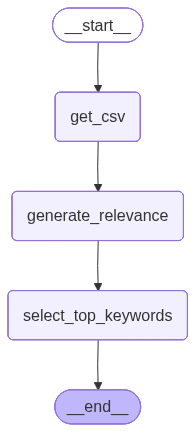

In [7]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())
     

In [12]:
test_data = {
    "product_name": 'chicken shredder',
    "product_description": 'chicken shredder',
	"category": 'chicken shredder'
}
for step in graph.stream(test_data):
   # step 딕셔너리의 첫 번째 키가 노드 이름입니다.
   node_name = list(step.keys())[0]
   node_output = step[node_name]

   print(f"--- Node: {node_name} ---")
   print(node_output)
   print("\n" + "="*30 + "\n")

데이터 프레임 보여주기


,Unnamed: 0,keyword,Search Volume,Competing Products,value_score
0,0,chicken shredder,11.855220,-0.296938,18.284614
1,1,chicken shredder tool twist,1.369935,-0.305422,3.412048
2,2,wedding registry items,0.344267,-0.286245,1.883374
3,3,mini chopper,0.147021,-0.072192,1.236270
4,4,chicken shredder tool,0.092690,-0.300452,1.561994
...,...,...,...,...,...
140,140,grinder for garlic,-0.113284,1.182809,0.406227
141,141,kalokelvin food chopper,-0.113284,-0.315562,1.295540
142,142,rival mini chopper,-0.113284,-0.315813,1.296015
143,143,the ultimate chopper,-0.113284,-0.304267,1.274507


--- Node: get_csv ---
{'data':      Unnamed: 0                           keyword  Search Volume  \
0             0                  chicken shredder      11.855220   
1             1       chicken shredder tool twist       1.369935   
2             2            wedding registry items       0.344267   
3             3                      mini chopper       0.147021   
4             4             chicken shredder tool       0.092690   
..          ...                               ...            ...   
140         140                grinder for garlic      -0.113284   
141         141           kalokelvin food chopper      -0.113284   
142         142                rival mini chopper      -0.113284   
143         143              the ultimate chopper      -0.113284   
144         144  suretivian chicken shredder tool            NaN   

     Competing Products  value_score  
0             -0.296938    18.284614  
1             -0.305422     3.412048  
2             -0.286245     1.88337